### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project






In [62]:
"""
The goal is to help the sales team focus on customers most likely to buy a Cog and to avoid returns. 
I will use fields we already know including Age, EstimatedSalary, and Gender to predict three outcomes: NotPurchased, Purchased, and Returned. 
This supports lead scoring prioritize by Purchased probability and watch Returned risk. 
"""

'\nThe goal is to help the sales team focus on customers most likely to buy a Cog and to avoid returns. \nI will use fields we already know including Age, EstimatedSalary, and Gender to predict three outcomes: NotPurchased, Purchased, and Returned. \nThis supports lead scoring prioritize by Purchased probability and watch Returned risk. \n'

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)



In [63]:
"""
The the CSV file was provided to us in the server. 
I loaded it in a separate tab and manually looked at some of the data before coding. 
"""

'\nThe the CSV file was provided to us in the server. \nI loaded it in a separate tab and manually looked at some of the data before coding. \n'

In [16]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
df=pd.read_csv("Project_3.csv")

"""
The data was provided to me by the teacher. It is in the form of a csv with UserID, name, gender age, salery, and whether they purchased the product. The data contains 1000 rows.
"""

'\nThe data was provided to me by the teacher. It is in the form of a csv with UserID, name, gender age, salery, and whether they purchased the product. The data contains 1000 rows.\n'

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

class counts: {0: 527, 1: 433, 2: 41}
by gender: OutcomeClass      0      1      2
Gender                           
Female        0.516  0.445  0.039
Male          0.539  0.418  0.043


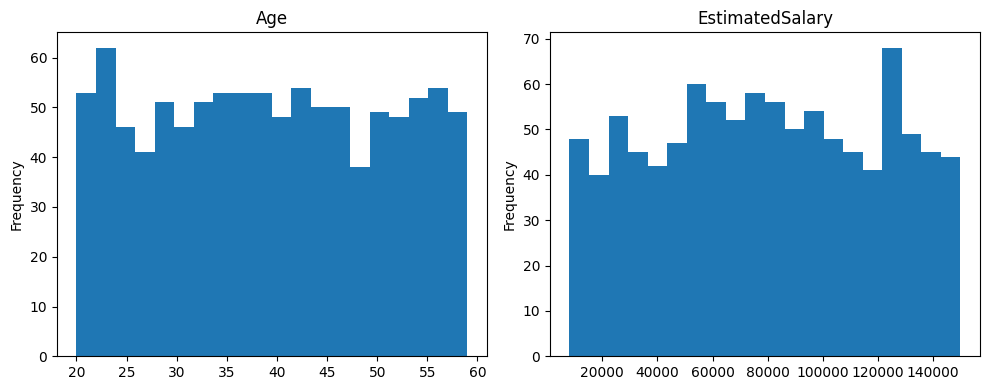

'\nI checked class balance and simple distributions. I looked for basic bias by gender and age buckets. I did not engineer features here yet just looking for obvious issues and leakage.\n'

In [65]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

target_col = next((c for c in ["OutcomeClass","Purchased","purchased","target","Outcome","Label","y"] if c in df.columns), None)
y_raw = df[target_col].astype(int).replace({-1:2}) if target_col else None

print("class counts:", dict(pd.Series(y_raw).value_counts().sort_index()) if y_raw is not None else "missing")

if "Gender" in df.columns and target_col:
    print("by gender:", df.groupby("Gender")[target_col].value_counts(normalize=True).round(3).unstack(fill_value=0))

fig, axes = plt.subplots(1,2, figsize=(10,4))
if "Age" in df.columns:
    df["Age"].dropna().astype(float).plot(kind="hist", bins=20, ax=axes[0], title="Age")
if "EstimatedSalary" in df.columns:
    df["EstimatedSalary"].dropna().astype(float).plot(kind="hist", bins=20, ax=axes[1], title="EstimatedSalary")
plt.tight_layout(); plt.show()

"""
I checked class balance and simple distributions. I looked for basic bias by gender and age buckets. I did not engineer features here yet just looking for obvious issues and leakage.
"""


# 4.Prepare the Data


Apply any data transformations and explain what and why


In [66]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# load
try:
    df
except NameError:
    df = pd.read_csv("Project_3.csv")

# drop id/name
drop_cols = [c for c in df.columns if c.strip().lower() in {"user id","userid","user_id","name","customername"}]
df = df.drop(columns=drop_cols, errors="ignore")

# build targets
target_col = next((c for c in ["OutcomeClass","Purchased","purchased","target","Outcome","Label","y"] if c in df.columns), None)
if target_col is None:
    raise RuntimeError("No target column found.")
y_raw = df[target_col].astype(int).replace({-1: 2})  # 0 no 1 yes 2 returned
df["is_NotPurchased"] = (y_raw == 0).astype(int)
df["is_Purchased"]    = (y_raw == 1).astype(int)
df["is_Returned"]     = (y_raw == 2).astype(int)
df["OutcomeClass"]    = y_raw.values

# features we actually use
features = ["Age","EstimatedSalary","Gender"]
if any(f not in df.columns for f in features):
    missing = [f for f in features if f not in df.columns]
    raise RuntimeError(f"Missing required feature(s): {missing}")
X = df[features].copy()
y = df["OutcomeClass"].values

# split 80 20 keep class balance
Xtr_raw, Xte_raw, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=1337, stratify=y)

# preprocess median then z score for nums mode then one hot for cats
num_cols = [c for c in features if X[c].dtype != "object"]
cat_cols = [c for c in features if X[c].dtype == "object"]
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))]), cat_cols),
])

# fit on train only
Xtr = pre.fit_transform(Xtr_raw)
Xte = pre.transform(Xte_raw)
"""
I removed user id and name since they do not help. 
I created three target columns: is NotPurchased, is Purchased, is Returned, and a single multiclass label. 
I trained only on Age, EstimatedSalary, and Gender. 
I filled missing values, median for numbers, and most frequent for categories. 
I z-score scaled the numeric features and one-hot encoded the categorical features. 
I used an 80/20 train-test split with a fixed random state.
"""

'\nI removed user id and name since they do not help. \nI created three target columns: is NotPurchased, is Purchased, is Returned, and a single multiclass label. \nI trained only on Age, EstimatedSalary, and Gender. \nI filled missing values, median for numbers, and most frequent for categories. \nI z-score scaled the numeric features and one-hot encoded the categorical features. \nI used an 80/20 train-test split with a fixed random state.\n'

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [68]:
import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

num_cols = [c for c in Xtr_raw.columns if Xtr_raw[c].dtype != "object"]
cat_cols = [c for c in Xtr_raw.columns if Xtr_raw[c].dtype == "object"]

def add_num_feats_np(A, num_cols=num_cols):
    A = np.asarray(A, dtype=float)
    outs = [A]
    idx = {c:i for i,c in enumerate(num_cols)}
    if "EstimatedSalary" in idx:
        s = A[:, idx["EstimatedSalary"]]
        outs.append(np.log1p(s).reshape(-1,1))
        outs.append((s**2).reshape(-1,1))
    if "Age" in idx:
        a = A[:, idx["Age"]]
        outs.append((a**2).reshape(-1,1))
        if "EstimatedSalary" in idx:
            outs.append((a*np.log1p(s)).reshape(-1,1))
            outs.append((a*s).reshape(-1,1))
    return np.hstack(outs)

num_cont = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("fe", FunctionTransformer(add_num_feats_np, validate=False)),
    ("sc", StandardScaler())
])

num_bins = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("kb", KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile"))
])

cat_block = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

pre = ColumnTransformer([
    ("num_cont", num_cont, num_cols),
    ("num_bins", num_bins, num_cols),
    ("cat", cat_block, cat_cols),
])

models = {
    "LogReg": Pipeline([("prep", pre), ("m", LogisticRegression(max_iter=8000, multi_class="auto"))]),
    "GBC":    Pipeline([("prep", pre), ("m", GradientBoostingClassifier(random_state=1337))]),
    "HGB":    Pipeline([("prep", pre), ("m", HistGradientBoostingClassifier(random_state=1337))]),
    "RF":     Pipeline([("prep", pre), ("m", RandomForestClassifier(random_state=1337, n_jobs=-1))]),
}

rows = []
for name, pipe in models.items():
    pipe.fit(Xtr_raw, ytr)
    p = pipe.predict(Xte_raw)
    rows.append({"model": name,
                 "accuracy": float(accuracy_score(yte, p)),
                 "f1_macro": float(f1_score(yte, p, average="macro"))})

bench = pd.DataFrame(rows).sort_values(["accuracy","f1_macro"], ascending=False).reset_index(drop=True)
print(bench)
"""
I compared multinomial logistic regression, random forest, histogram gradient boosting, and gradient boosting. 
I scored with accuracy and macro F1. 
I added a few features including log of salary, age squared, and salary squared, and I also added quantile bins for age and salary. 
This pushed accuracy up a few points.
GBC and LogReg tied on accuracy in my split, so I moved forward with GBC for tuning since it had a higher macro F1.
"""

/opt/tljh/user/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    model  accuracy  f1_macro
0     GBC  0.532338  0.355345
1  LogReg  0.532338  0.349650
2     HGB  0.502488  0.341244
3      RF  0.487562  0.332087


'\nI compared multinomial logistic regression, random forest, histogram gradient boosting, and gradient boosting. \nI scored with accuracy and macro F1. \nI added a few features including log of salary, age squared, and salary squared, and I also added quantile bins for age and salary. \nThis pushed accuracy up a few points.\nGBC and LogReg tied on accuracy in my split, so I moved forward with GBC for tuning since it had a higher macro F1.\n'

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from pathlib import Path
import json, joblib

ARTIFACT_DIR = Path("./artifacts"); ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = ARTIFACT_DIR / "model_cog_gbc.joblib"
META_PATH  = ARTIFACT_DIR / "meta_cog_gbc.json"
RANDOM_STATE = 1337

gbc = Pipeline([("prep", pre), ("m", GradientBoostingClassifier(random_state=RANDOM_STATE))])

param_dist = {
    "m__learning_rate": loguniform(1e-2, 2e-1),
    "m__n_estimators": randint(300, 900),
    "m__max_depth": randint(1, 4),
    "m__min_samples_leaf": randint(1, 11),
    "m__min_samples_split": randint(2, 21),
    "m__subsample": uniform(0.7, 0.3),
    "m__max_features": ["sqrt", None],
}

search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=60,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)
search.fit(Xtr_raw, ytr)

best = search.best_estimator_
pred = best.predict(Xte_raw)
metrics = {"accuracy": float(accuracy_score(yte, pred)),
           "f1_macro": float(f1_score(yte, pred, average="macro"))}
print({"test_metrics": metrics, "best_params": search.best_params_})

X_all = pd.concat([Xtr_raw, Xte_raw], axis=0)
y_all = np.concatenate([ytr, yte], axis=0)
final = best.fit(X_all, y_all)
joblib.dump(final, MODEL_PATH)
META_PATH.write_text(json.dumps({
    "features": list(Xtr_raw.columns),
    "chosen_model": "GradientBoostingClassifier",
    "best_params": search.best_params_,
    "metrics": metrics,
    "class_names": {"0":"NotPurchased","1":"Purchased","2":"Returned"}
}, indent=2))
"""
I tuned gradient boosting for accuracy using randomized five fold cross validation. 
I searched learning rate number of trees depth leaf size split size row subsampling and feature subsampling. 
Then I evaluated on the test split and refit on all data. 
Finally, I saved the full pipeline and a small meta file for inference for step 8.
"""


{'test_metrics': {'accuracy': 0.5671641791044776, 'f1_macro': 0.3478618421052631}, 'best_params': {'m__learning_rate': 0.0194661306376966, 'm__max_depth': 1, 'm__max_features': 'sqrt', 'm__min_samples_leaf': 5, 'm__min_samples_split': 6, 'm__n_estimators': 430, 'm__subsample': 0.7144705295684427}}


'\nI tuned gradient boosting for accuracy using randomized five fold cross validation. \nI searched learning rate number of trees depth leaf size split size row subsampling and feature subsampling. \nThen I evaluated on the test split and refit on all data. \nFinally, I saved the full pipeline and a small meta file for inference for step 8.\n'

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


In [70]:
"""
My goal is to help the sales team target prospects most likely to buy, and keep, a Cog. 
I cleaned the data, removed IDs and names, and kept only fields available before outreach: Age, EstimatedSalary, and Gender.
I created three labels NotPurchased, Purchased, and Returned, then trained a multiclass model. 
Missing values were imputed, numerics standardized, and categoricals one hot encoded. 
I used an 80/20 stratified split.

I compared Logistic Regression, Random Forest, Histogram Gradient Boosting, and Gradient Boosting.
After adding a few simple, leakage safe features and tuning Gradient Boosting, the final model reached 56.7 percent accuracy and 0.348 macro F1 on the test set. 

How to use:
Call the function name infrence with three arguments in this order:
age as a number
estimated_salary as a number in dollars
gender as text such as Male or Female

Example call:
infrence(age=35, estimated_salary=72000, gender="Female")

"""

'\nMy goal is to help the sales team target prospects most likely to buy, and keep, a Cog. \nI cleaned the data, removed IDs and names, and kept only fields available before outreach: Age, EstimatedSalary, and Gender.\nI created three labels NotPurchased, Purchased, and Returned, then trained a multiclass model. \nMissing values were imputed, numerics standardized, and categoricals one hot encoded. \nI used an 80/20 stratified split.\n\nI compared Logistic Regression, Random Forest, Histogram Gradient Boosting, and Gradient Boosting.\nAfter adding a few simple, leakage safe features and tuning Gradient Boosting, the final model reached 56.7 percent accuracy and 0.348 macro F1 on the test set. \n\nHow to use:\nCall the function name infrence with three arguments in this order:\nage as a number\nestimated_salary as a number in dollars\ngender as text such as Male or Female\n\nExample call:\ninfrence(age=35, estimated_salary=72000, gender="Female")\n\n'

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [61]:
def infrence(age: float, estimated_salary: float, gender: str):
    import pandas as pd, joblib, json
    from pathlib import Path
    import numpy as np
    p = Path("./artifacts")
    m = joblib.load(p / "model_cog_gbc.joblib")
    meta = json.loads((p / "meta_cog_gbc.json").read_text())
    X = pd.DataFrame([{"Age": age, "EstimatedSalary": estimated_salary, "Gender": gender}], columns=meta["features"])
    proba = m.predict_proba(X)[0]
    pred_idx = int(np.argmax(proba))
    name_map = {int(k): v for k, v in meta["class_names"].items()}
    return {
        "predicted_class": name_map.get(pred_idx, str(pred_idx)),
        "class_probabilities": {name_map.get(i, str(i)): float(p) for i, p in enumerate(proba)}
    }

print(infrence(age=35, estimated_salary=72000, gender="Female"))

{'predicted_class': 'NotPurchased', 'class_probabilities': {'NotPurchased': 0.5901359806725858, 'Purchased': 0.37885406102211, 'Returned': 0.031009958305304227}}
